# Summary

Taking data from 18,052 schools (2018 - 2023), I built a deep learning linear regression model in Pytorch to predict California Science Test (CAST) schoolwide scores based on student income.

The model is able to predict school test scores with 91% accuracy.

A deep learning approach was chosen to build my skills, in reality for a linear regression of this size and complexity I would use more traditional statisical analysis.

A linear regression was chosen because of the observed linear relationship between the target and predictor variable.  

# Data Sourcing





The population of study is all 5th grade classes in California, from 2018-2023, omitting the 2019-2020 school year, where data was not available.



Student test score data taken from the [California Science Test (CAST) website](https://caaspp-elpac.ets.org/caaspp/ResearchFileListCAST?ps=true&lstTestYear=2022&lstTestType=X&lstCounty=00&lstDistrict=00000
).

Initial cleaning done in GSheets. Cleaning steps:
* Removed all non-5th grade scores.
* Removed all columns aside from "School Code", "Test Year," "Grade" ,"Percentage Standard Met and Above".
* Removed rows that were totals and subtotals
* Removed  duplicates and null values
* Sorted by each column value to visually inspect for outliers, and removed School Code 1996115 as they had 2938 tested, 900 more than the next school tested.

The cleaned dataset is [here](https://docs.google.com/spreadsheets/d/1YgrLDP4da_9hLfpIIOw8bRmRSzRSGdifsaa980oq8jQ/edit#gid=1602465879).
Cleaned n = 18,338.


---


Student income and charter school data taken from the [California Free or Reduced-Price Meal (FRPM) program website](https://www.cde.ca.gov/ds/ad/filessp.asp).

Initial cleaning done in GSheets. Cleaning steps:

* Removed all columns aside from "School Code", Academic Year", "District Name", "School Name", "School Type", "Educational Option Type", "Charter School", "Percent Eligible FRPM (K-12)".
* Removed all 'education option types' that weren't 'Traditional'
* Deleted all schools that were high school or middle school only, keeping K-12s
* Deleted all schools with 0% FRPM eligibility, believing this to be an error.
* Removed duplicates and null values
* Dummy-encoded Charter School Yes/No as 1/0

The cleaned dataset is [here](https://docs.google.com/spreadsheets/d/1dsYwaWm5c9O8YhziFta8lrVAftiKVIAV1iY_V8UHYWY/edit#gid=0) Cleaned n = 35,508


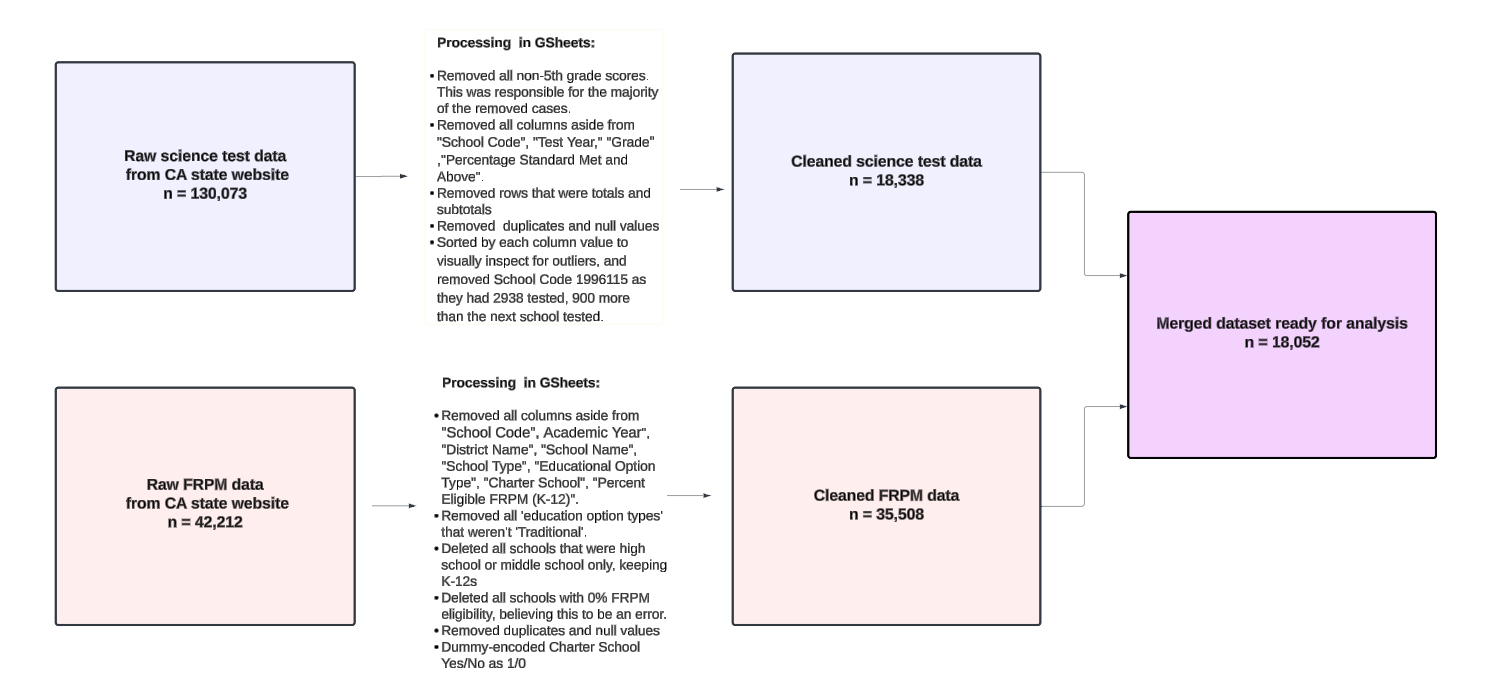

#Import, merge, and explore data


In [ ]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.float_format", lambda x: "%.5f" % x) # To get out of scientific notation.  Use pd.reset_option('display.float_format') to reset back to the default


In [ ]:
# Import the csv files
scores_df = pd.read_csv('https://raw.githubusercontent.com/corbiephillips/Reviewing-CA-school-districts-to-identify-performance-above-and-below-income-based-expectations/main/CAST%20Scores%202019%2C%202021%2C%202022%2C%202023%20%20-%20Sheet1.csv')
income_df = pd.read_csv('https://raw.githubusercontent.com/corbiephillips/Reviewing-CA-school-districts-to-identify-performance-above-and-below-income-based-expectations/main/FRPM%202019%2C%202021%2C%202022%2C%202023%20-%20Sheet2%20(1).csv')


In [ ]:
# Confirm the importing went correctly
scores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18338 entries, 0 to 18337
Data columns (total 4 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   School Code                        18338 non-null  int64  
 1   Test Year                          18338 non-null  int64  
 2   Grade                              18338 non-null  int64  
 3   Percentage Standard Met and Above  18338 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 573.2 KB


In [ ]:
scores_df.rename(columns={'Test Year': 'Year'}, inplace=True)
scores_df.head()

,School Code,Year,Grade,Percentage Standard Met and Above
0,6008379,2022,5,0.88000
1,106955,2023,5,1.12000
2,6051395,2019,5,1.30000
3,6106694,2019,5,1.37000
4,6049803,2023,5,1.45000


In [ ]:
income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35508 entries, 0 to 35507
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   School Code                         35508 non-null  int64  
 1   Academic Year                       35508 non-null  int64  
 2   District Name                       35508 non-null  object 
 3   School Name                         35508 non-null  object 
 4   School Type                         35508 non-null  object 
 5   Educational 
Option Type            35508 non-null  object 
 6   Charter 
School 
(0=No, 1 = Yes)    35508 non-null  int64  
 7   Percent (%) 
Eligible FRPM 
(K-12)  35508 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 2.2+ MB


In [ ]:
income_df.rename(columns={'Academic Year': 'Year', 'Educational \nOption Type': 'Educational Option Type', 'Charter \nSchool \n(0=No, 1 = Yes)': 'Charter School', 'Percent (%) \nEligible FRPM \n(K-12)': 'Percent Eligible FRPM (K-12)'}, inplace=True)
income_df.head()

,School Code,Year,District Name,School Name,School Type,Educational Option Type,Charter School,Percent Eligible FRPM (K-12)
0,6007033,2019,Parlier Unified,Mathew J Brletic Elementary,Elementary Schools (Public),Traditional,0,100.00000
1,6006647,2019,Golden Plains Unified,Helm Elementary,Elementary Schools (Public),Traditional,0,100.00000
2,1030774,2019,Washington Unified,W.E.B. DuBois Public Charter,K-12 Schools (Public),Traditional,1,100.00000
3,1132109,2019,Stony Creek Joint Unified,Elk Creek Junior-Senior High,High Schools (Public),Traditional,0,100.00000
4,6007553,2019,Stony Creek Joint Unified,Indian Valley Elementary,Elementary Schools (Public),Traditional,0,100.00000


In [ ]:
# Join the two data sets using inner join, to only include income data for schools I also have test score data for.
student_df = pd.merge(scores_df, income_df, how='inner', on=['School Code', 'Year'])

In [ ]:
student_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18052 entries, 0 to 18051
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   School Code                        18052 non-null  int64  
 1   Year                               18052 non-null  int64  
 2   Grade                              18052 non-null  int64  
 3   Percentage Standard Met and Above  18052 non-null  float64
 4   District Name                      18052 non-null  object 
 5   School Name                        18052 non-null  object 
 6   School Type                        18052 non-null  object 
 7   Educational Option Type            18052 non-null  object 
 8   Charter School                     18052 non-null  int64  
 9   Percent Eligible FRPM (K-12)       18052 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 1.4+ MB


In [ ]:
student_df.head()

,School Code,Year,Grade,Percentage Standard Met and Above,District Name,School Name,School Type,Educational Option Type,Charter School,Percent Eligible FRPM (K-12)
0,6008379,2022,5,0.88000,Calexico Unified,Rockwood Elementary,Elementary Schools (Public),Traditional,0,94.03255
1,106955,2023,5,1.12000,Los Angeles Unified,Harmony Elementary,Elementary Schools (Public),Traditional,0,98.34025
2,6051395,2019,5,1.30000,Vallejo City Unified,Johnston Cooper Elementary,Elementary Schools (Public),Traditional,0,82.00000
3,6106694,2019,5,1.37000,Adelanto Elementary,Westside Park Elementary,Elementary Schools (Public),Traditional,0,87.60000
4,6049803,2023,5,1.45000,Pajaro Valley Unified,T. S. MacQuiddy Elementary,Elementary Schools (Public),Traditional,0,89.31116


In [ ]:
student_df.isnull().sum()

# Duplicates were checked for in GSheets before importing the data.

School Code                          0
Year                                 0
Grade                                0
Percentage Standard Met and Above    0
District Name                        0
School Name                          0
School Type                          0
Educational Option Type              0
Charter School                       0
Percent Eligible FRPM (K-12)         0
dtype: int64

<Axes: xlabel='Percent Eligible FRPM (K-12)', ylabel='Count'>

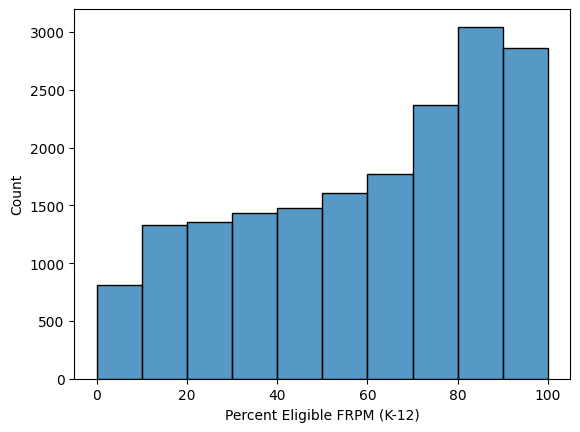

In [ ]:
# Plot the income distribution
sns.histplot(student_df['Percent Eligible FRPM (K-12)'], bins=10)


The income distribution is left skewed, with more children at the lower income ranges.



<Axes: xlabel='Percentage Standard Met and Above', ylabel='Count'>

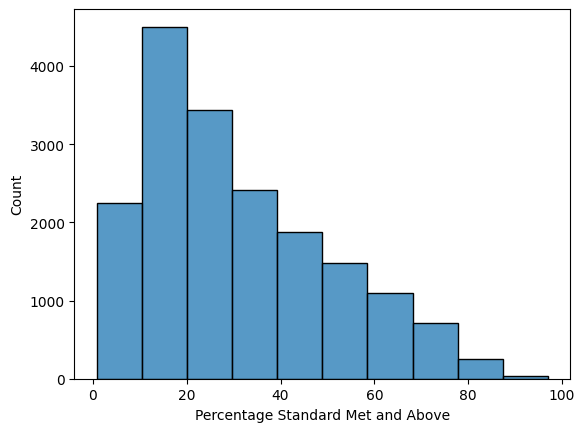

In [ ]:
# Plot the test score distribution
sns.histplot(student_df['Percentage Standard Met and Above'], bins=10)


The test score distribution is right skewed with more scores at the lower-performing levels

In [ ]:
# This analysis relies on the assumption that FRPM eligibilty is related to test scores. Checking via correlation coefficient
correlation = student_df['Percent Eligible FRPM (K-12)'].corr(student_df['Percentage Standard Met and Above'])
print(correlation)

-0.8189322742549194


-0.82 is a strong negative correlation.

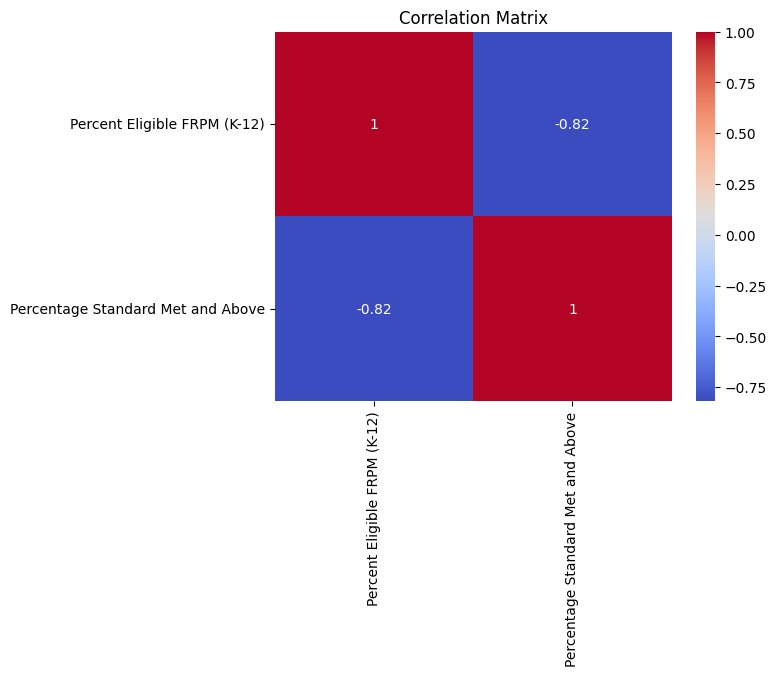

In [ ]:
# Remove the parts of the dataframe that will not be in the regression model
regression_df = student_df[['Percent Eligible FRPM (K-12)', 'Percentage Standard Met and Above']]

corr_matrix = regression_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

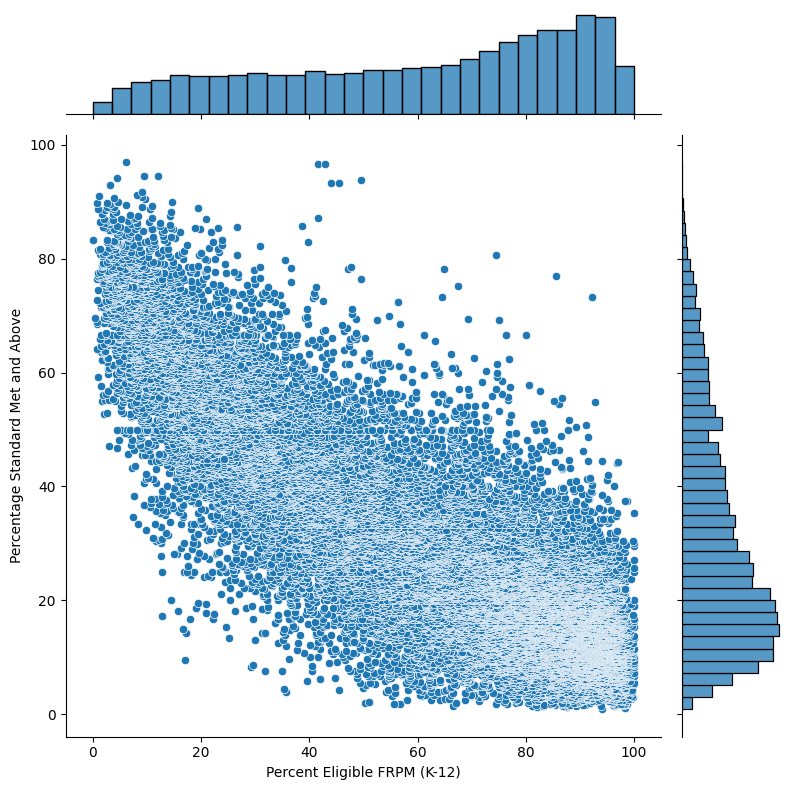

In [ ]:
sns.jointplot(
    data=student_df,
    x='Percent Eligible FRPM (K-12)',
    y='Percentage Standard Met and Above',
    height=8,
    ratio=5)

Visual inspection for outliers, no outliers detected.  All values are bounded between 0 and 100.

# Fit the deep learning model on student_df

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [ ]:
# Split into training and test sets
from sklearn.model_selection import train_test_split
regression_df_train, regression_df_test = train_test_split(regression_df, test_size=0.2, random_state=18)

# separate out the target variable y from the others
X_train, y_train = regression_df_train.iloc[:, :-1], regression_df_train.iloc[:,[-1]]
X_test, y_test = regression_df_test.iloc[:, :-1], regression_df_test.iloc[:,[-1]]

In [ ]:
# Scale
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.values) # .values makes it a numpy array instead of a dataframe. Torch.float needs a numpy array
X_test = scaler.transform(X_test.values)  # fit does the calculation to determine how the scaling should be done, and transform does the actual scaling. We transform without fitting on the test set to avoid data leakage.
y_train = y_train.values
y_test = y_test.values

# Convert back to torch tensors with the correct dtype using torch.float32
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float32, requires_grad=True))
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float32, requires_grad=True))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [ ]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())


[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 3611
Number of predictions made: 3611
Predicted values:
tensor([[ 0.5209],
        [-0.5321],
        [-0.3409],
        ...,
        [-0.3319],
        [ 0.4553],
        [ 0.2676]])


In [ ]:
# Create the loss function
loss_fn = nn.L1Loss() # Mean Abso loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))


In [ ]:
torch.manual_seed(18)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 20000

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss.detach().numpy()} | MAE Test Loss: {test_loss.detach().numpy()} ")


Streaming output truncated to the last 5000 lines.
        [14.8164],
        [22.5834]], grad_fn=<AddBackward0>)
tensor([[14.5960],
        [18.7021],
        [30.8853],
        ...,
        [54.4994],
        [14.8164],
        [22.5834]], grad_fn=<AddBackward0>)
tensor([[14.5960],
        [18.7021],
        [30.8853],
        ...,
        [54.4994],
        [14.8164],
        [22.5834]], grad_fn=<AddBackward0>)
tensor([[14.5960],
        [18.7021],
        [30.8853],
        ...,
        [54.4994],
        [14.8164],
        [22.5834]], grad_fn=<AddBackward0>)
tensor([[14.5960],
        [18.7021],
        [30.8853],
        ...,
        [54.4994],
        [14.8164],
        [22.5834]], grad_fn=<AddBackward0>)
tensor([[14.5960],
        [18.7021],
        [30.8853],
        ...,
        [54.4994],
        [14.8164],
        [22.5834]], grad_fn=<AddBackward0>)
Epoch: 19300 | MAE Train Loss: 8.66634464263916 | MAE Test Loss: 8.722436904907227 
tensor([[14.5960],
        [18.7021],
    

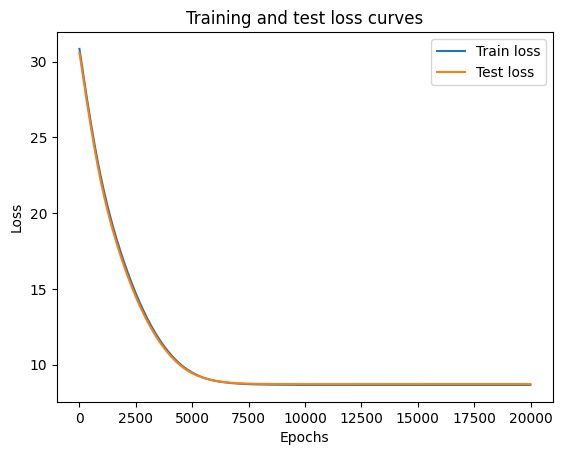

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();


In [ ]:
loss.item() # Gives the final scalar value of the loss

8.666343688964844

The final loss value (mean absolute error) is 8.7%.

This means that the model will predict the percentage of a school that met or exceeded CAST scores with an average error of 8.7%.  This is an improvement from 30% error before training the model.


# Saving the model for export

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1680 Jun 16 19:46 models/01_pytorch_workflow_model_0.pth
